In [ ]:
# random forest for comparison, this tells us that maybe DNN is not the best model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Random Forest R²: 0.9233577682525691


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('../datasets/MEGAFRAME_CLEANEDV2.csv')

# Remove both targets and irrelevant columns from features
X = df.drop(columns=['Gini index', 'UNEMP', 'Reference area', 'REF_AREA', 'Region'])
y = df['Gini index']

categorical_features = ['TIME_PERIOD']
numerical_features = X.columns.difference(categorical_features)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
# Chat GPT gave me the idea to do droupout layers, the lower I used the better the model performed
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=300, batch_size=8, validation_split=0.1, callbacks=[early_stop])

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")

new_data = pd.DataFrame({
    'TIME_PERIOD': [2001],
    'Trade union density': [78.699997],
    'Combined corporate income tax rate': [28.0],
    'Education spending': [0.0734319847255705],
    'Health spending': [0.0631525528524754],
    'Housing spending': [0.0057497428086187],
    'Community development spending': [0.0025634702523358],
    'IRLT': [5.1075],
    'Population, total': [8895960.0],
    'GDP per capita (current US$)': [27259.4806735435],
    'Inflation, consumer prices (annual %)': [2.40595834145438]
})

new_data_processed = preprocessor.transform(new_data)
predicted_gini = model.predict(new_data_processed)
print(f"Predicted Gini: {predicted_gini.flatten()[0]:.2f}")


Epoch 1/300


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 940.8663 - mae: 30.1803 - val_loss: 954.1045 - val_mae: 30.6802
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 851.8884 - mae: 28.6689 - val_loss: 878.9827 - val_mae: 29.4452
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 708.5175 - mae: 26.0839 - val_loss: 741.2808 - val_mae: 26.9710
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 561.8658 - mae: 22.8130 - val_loss: 541.4696 - val_mae: 22.7405
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 380.0973 - mae: 18.1351 - val_loss: 321.9977 - val_mae: 16.9240
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 234.8989 - mae: 13.4394 - val_loss: 135.0238 - val_mae: 9.4528
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 139.0978 - mae: 9.7321 - val_loss: 64.8766 - val_mae: 6.0992
Epoch 8/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75.4288 - mae: 7.0228 - val_loss: 33.4038 - val_mae: 4.5946
Epoch 9/300
36/36 ━━━━━━━━━━━━━━━━━

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MAE: 2.23
MSE: 10.81
RMSE: 3.29
R² Score: 0.69


In [53]:
from sklearn.metrics import mean_absolute_error, r2_score

mae_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_processed):
    X_train, X_val = X_processed[train_index], X_processed[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    
    y_val_pred = model.predict(X_val).flatten()
    
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    mae_scores.append(mae)
    r2_scores.append(r2)

print(f"Mean MAE over 5 folds: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
print(f"Mean R² over 5 folds: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Mean MAE over 5 folds: 1.93 ± 0.16
Mean R² over 5 folds: 0.7293 ± 0.0907


In [ ]:
print("Summary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes)


Summary Statistics:
       TIME_PERIOD  Trade union density  Combined corporate income tax rate  \
count   400.000000           400.000000                          400.000000   
mean   2010.605000            32.947000                           25.384909   
std       5.088094            21.854253                            6.892238   
min    2000.000000             7.100000                            9.000000   
25%    2006.750000            16.600000                           20.000000   
50%    2011.000000            25.050000                           25.000000   
75%    2015.000000            49.825000                           30.000000   
max    2020.000000            91.599998                           51.611553   

       Education spending  Health spending  Housing spending  \
count          400.000000       400.000000        400.000000   
mean             0.052006         0.064127          0.003168   
std              0.014906         0.017721          0.003309   
min         

In [64]:
weights = model.get_weights()

# Each item in `weights` is either a weight matrix or bias vector for a layer
for i, w in enumerate(weights):
    print(f"Weight {i} shape: {w.shape}")
    print(w[:5])  # show the first 5 values (or rows if 2D)

Weight 0 shape: (31, 128)
[[ 4.00353372e-02 -4.89444397e-02  3.21174855e-03 -2.06976771e-01
  -1.77904516e-01 -1.99724928e-01 -1.93760663e-01  1.68917254e-01
   1.35592550e-01  7.11843893e-02  1.33314267e-01  1.33903772e-01
  -1.88693717e-01  2.25412801e-01 -4.12906893e-02 -1.93315282e-01
   2.24756431e-02  6.94499761e-02 -9.08202156e-02 -1.63324729e-01
   1.03880845e-01  7.44698644e-02 -3.48716043e-02 -7.09798858e-02
  -4.96270694e-02 -1.75219685e-01 -4.19567414e-02 -5.14569245e-02
  -2.20649287e-01 -1.68454811e-01 -3.21014151e-02 -9.35234651e-02
   1.46608889e-01  5.80590367e-02 -1.33556304e-02  2.00247943e-01
   4.92242351e-03  1.35668591e-01 -1.53251693e-01 -5.49108200e-02
  -1.29620790e-01  3.67945991e-02 -1.72417790e-01 -7.18517005e-02
   5.96208870e-02  7.58613124e-02 -7.45347962e-02 -7.64463246e-02
  -8.57527107e-02  1.52691662e-01 -1.38089865e-01 -9.17177945e-02
   3.97566669e-02  1.36668514e-02 -2.00625420e-01  9.80460197e-02
  -1.96531758e-01 -1.13512523e-01  4.17773239e-02 

### ABOVE WAS THE GINI INDEX BEING PREDICTED, THE MODEL PERFORMS BETTER THAN LOGISTIC AND LINEAR

In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('../datasets/MEGAFRAME_CLEANEDV2.csv')

X = df.drop(columns=['UNEMP', 'Reference area', 'REF_AREA', 'TIME_PERIOD'])
y = df['UNEMP']

categorical_features = ['Region']
numerical_features = X.columns.difference(categorical_features)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.02),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.02),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=300, batch_size=8, validation_split=0.1, callbacks=[early_stop])

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE (Unemployment): {mae:.2f}")

new_data = pd.DataFrame({
    'Region': ['Europe and Central Asia'],  
    'Trade union density': [78.699997],
    'Combined corporate income tax rate': [28.0],
    'Education spending': [0.0734319847255705],
    'Health spending': [0.0631525528524754],
    'Housing spending': [0.0057497428086187],
    'Community development spending': [0.0025634702523358],
    'IRLT': [5.1075],
    'Population, total': [8895960.0],
    'GDP per capita (current US$)': [27259.4806735435],
    'Inflation, consumer prices (annual %)': [2.40595834145438],
    'Gini index': [26.5]
})

new_data_processed = preprocessor.transform(new_data)

predicted_unemp = model.predict(new_data_processed)
print(f"Predicted Unemployment: {predicted_unemp.flatten()[0]:.2f}")


Epoch 1/300


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 58.4354 - mae: 6.3080 - val_loss: 55.8366 - val_mae: 6.3160
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37.4434 - mae: 4.7737 - val_loss: 43.4969 - val_mae: 5.4484
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.4705 - mae: 3.2056 - val_loss: 30.9263 - val_mae: 4.3333
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.9029 - mae: 2.9179 - val_loss: 22.1314 - val_mae: 3.3644
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.8261 - mae: 2.4360 - val_loss: 15.9456 - val_mae: 2.7560
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6557 - mae: 2.2217 - val_loss: 12.6280 - val_mae: 2.3691
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.4873 - mae: 2.6126 - val_loss: 11.7230 - val_mae: 2.2662
Epoch 8/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0834 - mae: 2.2153 - val_loss: 9.1934 - val_mae: 2.0003
Epoch 9/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0

In [127]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
MAE: 1.52
MSE: 6.87
RMSE: 2.62
R² Score: 0.56


In [128]:
import tensorflow as tf

model.save('Unemployment.keras')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


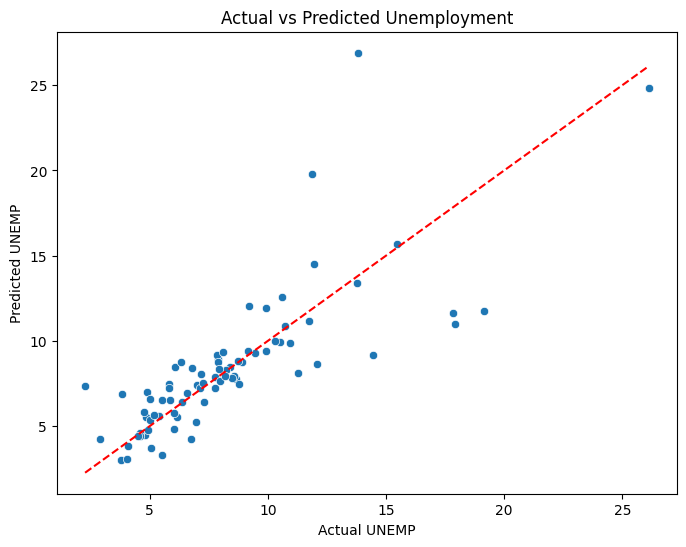

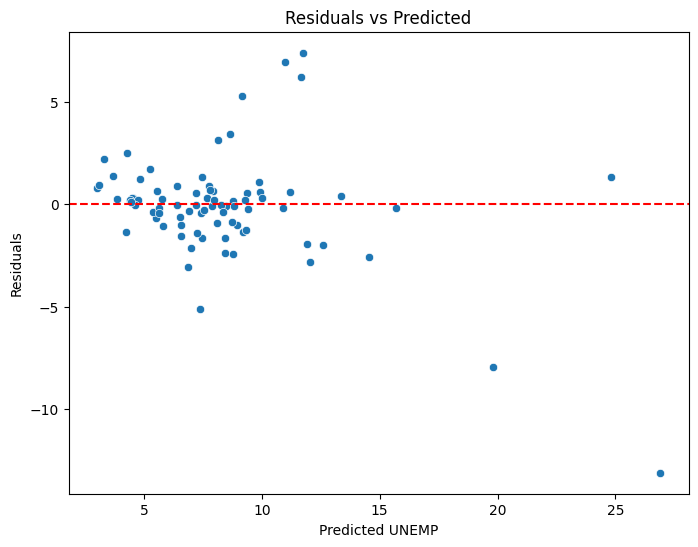

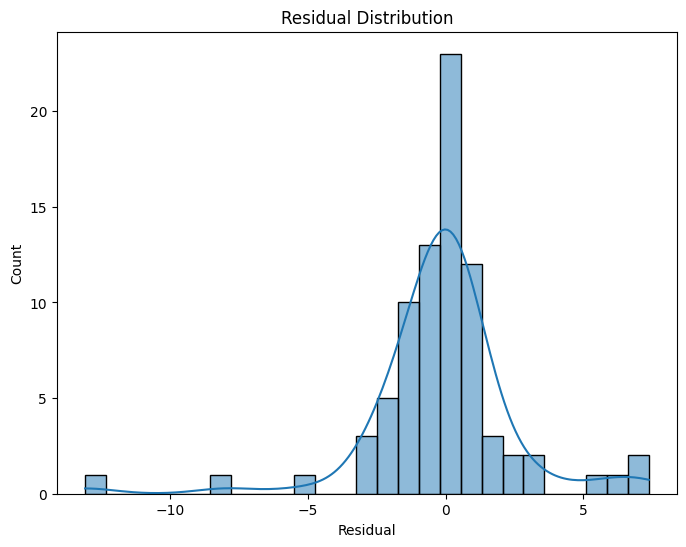

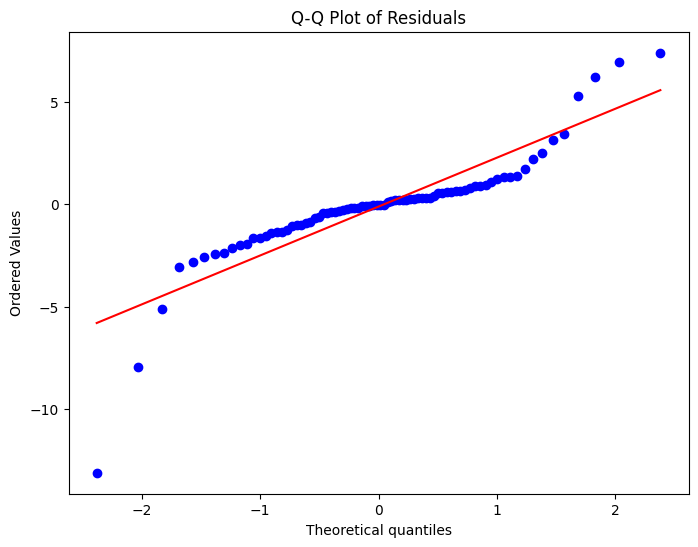

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on test set
y_pred = model.predict(X_test).flatten()

# Residuals
residuals = y_test - y_pred

# Plot 1: Predicted vs Actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual UNEMP')
plt.ylabel('Predicted UNEMP')
plt.title('Actual vs Predicted Unemployment')
plt.show()

# Plot 2: Residuals vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted UNEMP')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# Plot 3: Histogram of Residuals
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residual')
plt.title('Residual Distribution')
plt.show()

# Optional: Q-Q plot for residual normality (requires scipy)
import scipy.stats as stats
plt.figure(figsize=(8,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


In [ ]:
weights = model.get_weights()


for i, w in enumerate(weights):
    print(f"Weight {i} shape: {w.shape}")
    print(w[:5])  # show the first 5 values (or rows if 2D)

Weight 0 shape: (31, 128)
[[ 4.00353372e-02 -4.89444397e-02  3.21174855e-03 -2.06976771e-01
  -1.77904516e-01 -1.99724928e-01 -1.93760663e-01  1.68917254e-01
   1.35592550e-01  7.11843893e-02  1.33314267e-01  1.33903772e-01
  -1.88693717e-01  2.25412801e-01 -4.12906893e-02 -1.93315282e-01
   2.24756431e-02  6.94499761e-02 -9.08202156e-02 -1.63324729e-01
   1.03880845e-01  7.44698644e-02 -3.48716043e-02 -7.09798858e-02
  -4.96270694e-02 -1.75219685e-01 -4.19567414e-02 -5.14569245e-02
  -2.20649287e-01 -1.68454811e-01 -3.21014151e-02 -9.35234651e-02
   1.46608889e-01  5.80590367e-02 -1.33556304e-02  2.00247943e-01
   4.92242351e-03  1.35668591e-01 -1.53251693e-01 -5.49108200e-02
  -1.29620790e-01  3.67945991e-02 -1.72417790e-01 -7.18517005e-02
   5.96208870e-02  7.58613124e-02 -7.45347962e-02 -7.64463246e-02
  -8.57527107e-02  1.52691662e-01 -1.38089865e-01 -9.17177945e-02
   3.97566669e-02  1.36668514e-02 -2.00625420e-01  9.80460197e-02
  -1.96531758e-01 -1.13512523e-01  4.17773239e-02 

In [69]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores, r2_scores = [], []

for fold, (train_index, val_index) in enumerate(kf.split(X_processed), 1):
    X_train, X_val = X_processed[train_index], X_processed[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Build model
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Train
    model.fit(X_train, y_train, epochs=300, batch_size=8,
              validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)

    # Predict and evaluate
    y_val_pred = model.predict(X_val).flatten()
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    mae_scores.append(mae)
    r2_scores.append(r2)
    print(f"Fold {fold} - MAE: {mae:.2f}, R²: {r2:.4f}")

# Final scores
print(f"\nMean MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Fold 1 - MAE: 1.56, R²: 0.5987


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Fold 2 - MAE: 1.73, R²: 0.6589


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Fold 3 - MAE: 1.67, R²: 0.7171


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Fold 4 - MAE: 1.87, R²: 0.5419


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Fold 5 - MAE: 1.48, R²: 0.6506

Mean MAE: 1.66 ± 0.14
Mean R²: 0.6334 ± 0.0592
